# **Image Captioning using Transformers**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importing neccessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
from tqdm import tqdm
import pickle as pk

import re
import random

# Preprocess the data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

# Model and Layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable

# For checking score
from nltk.translate.bleu_score import sentence_bleu

In [3]:
INPUT_DIR = "/kaggle/input/flickr30k"
WORKING_DIR = "/kaggle/working"

In [4]:
## Load the data
data = pd.read_csv(f"{INPUT_DIR}/captions.txt", sep=",")
data.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [5]:
data.shape

(158915, 2)

In [6]:
# Total no. of unique images in the data
data["image"].nunique()

31783

`Every Image in the data is labelled with 5 captions`

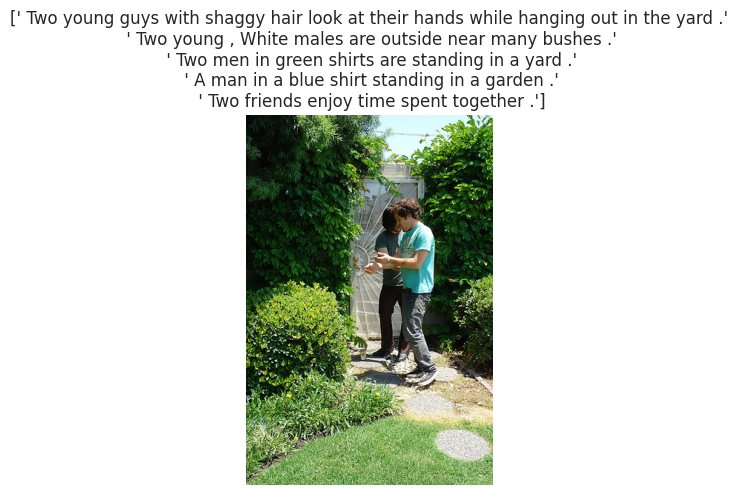

In [7]:
# Print 1st image with caption
image_0_path = f"{INPUT_DIR}/Images/flickr30k_images/{data.image[0]}"
image_0 = load_img(image_0_path, color_mode="rgb")
plt.imshow(image_0)
plt.title(f"{data.caption[:5].values}")
plt.axis("off")
plt.show()

### **Text Preprocessing**

In [8]:
data.isnull().sum()

image      0
caption    1
dtype: int64

In [9]:
def clean_text(data):
    # drop the Nan-valued rows
    data = data.dropna()
    # convert all words into lower-case
    data["caption"] = data["caption"].apply(lambda x: x.lower())
    # remove characters other than alphabets
    data["caption"] = data["caption"].apply(lambda x: x.replace("[^a-zA-Z]",""))
    # replace extra spaces,tabs,etc with single-space
    data["caption"] = data["caption"].apply(lambda x: x.replace("\s+"," "))
    # remove any leading or trailing whitespace from the text
    data["caption"] = data["caption"].str.strip()
    # include Start_of_Seq and End_of_Seq in each caption
    data["caption"] = "startseq "+data["caption"]+" endseq"
    return data

# perform cleaning on text data (captions)
data = clean_text(data)
captions = data["caption"].tolist()
captions[:5]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard . endseq',
 'startseq two young , white males are outside near many bushes . endseq',
 'startseq two men in green shirts are standing in a yard . endseq',
 'startseq a man in a blue shirt standing in a garden . endseq',
 'startseq two friends enjoy time spent together . endseq']

In [10]:
# maximum length of tokenized-captions
MAX_LENGTH = 30

# maximum number of unique tokens in vocabularly
MAX_TOKENS = 10000

# no. of samples that will pass through the network at once
BATCH_SIZE = 128

# shuffling the dataset
BUFFER_SIZE = 1000

# dimension of the word-embeddings
EMBEDDING_DIM = 512

# no. of units in the Feed-Forward layers
UNITS = 512

# no. of epochs to train
EPOCHS = 20

In [11]:
# Text-Tokenization and Sequence-encoded representation
tokenizer = tf.keras.layers.TextVectorization(
      max_tokens=MAX_TOKENS,
      standardize=None,
      output_sequence_length=MAX_LENGTH,      #specifies the length of the output sequences
)

# Adapting the Tokenizer to all captions
tokenizer.adapt(data['caption'])

In [12]:
# Size of the vocabulary
tokenizer.vocabulary_size()

10000

In [13]:
with open(f"{WORKING_DIR}/tokenizer.pkl", 'wb') as file:
    pk.dump(tokenizer, file)

In [14]:
# The vocabulary is obtained from the tokenizer using the get_vocabulary() method, which returns a list of strings
# representing the vocabulary in order of frequency (most frequent first)
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', 'startseq', 'endseq', '.', 'in', 'the', 'on', 'and']

In [15]:
#layer that maps strings to integer indices.
word_to_index = tf.keras.layers.StringLookup(
      mask_token="",
      vocabulary=tokenizer.get_vocabulary()
)


index_to_word = tf.keras.layers.StringLookup(
      mask_token="",
      vocabulary=tokenizer.get_vocabulary(),
      invert=True
)

## **Train-Test Split**

In [16]:
# initializing a defaultdict with lists as the default value type
img_to_cap_mapping = collections.defaultdict(list)

for img, caption in zip(data['image'], data['caption']):
    img_to_cap_mapping[img].append(caption)

# Shuffling and Splitting Keys
img_keys = list(img_to_cap_mapping.keys())
random.shuffle(img_keys)

# split 90% for Training & 10% for Validation
split = int(len(img_keys)*0.90)
train_img_keys, val_img_keys = (img_keys[:split], img_keys[split:])


# Creating Training and Validation Data
train_imgs = []
train_captions = []
for img in train_img_keys:
    caption_len = len(img_to_cap_mapping[img])
    train_imgs.extend([img] * caption_len)
    train_captions.extend(img_to_cap_mapping[img])

val_imgs = []
val_captions = []
for img in val_img_keys:
    caption_len = len(img_to_cap_mapping[img])
    val_imgs.extend([img] * caption_len)
    val_captions.extend(img_to_cap_mapping[img])


In [17]:
def load_data(img_path, caption):
    #reads the image file
    img = tf.io.read_file(f"{INPUT_DIR}/Images/flickr30k_images/"+img_path)
    #decodes the JPEG-encoded image into a 3D tensor
    img = tf.io.decode_jpeg(img, channels=3)
    #resizes the image to the desired dimensions
    img = tf.keras.layers.Resizing(224, 224)(img)
    #normalize
    img = img / 255.
    #tokenizes the caption using the tokenizer created earlier
    caption = tokenizer(caption)
    return img, caption

In [18]:
# Dataset Creation
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
# 1st batch [image, tokenized-captions]
dataset = train_dataset.take(1)
dataset = dataset.batch(1)
for element in dataset:
    print(element[0].dtype, element[1].dtype)
    print(element[0].shape, element[1].shape)

<dtype: 'float32'> <dtype: 'int64'>
(1, 128, 224, 224, 3) (1, 128, 30)


### Pre-trained CNN Model for Feature Extraction 

In [ ]:
# Defined a Class that loads pretrained CNN-model for Image-Feature-Extraction

@register_keras_serializable()
class CNN_Encoder(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # load VGG16-model
        base_model = tf.keras.applications.VGG16(include_top=False,
                                                    input_shape=(224, 224, 3),
                                                    pooling='max',
                                                    weights='imagenet')
        # Freezing all layer's weights
        for layer in base_model.layers:
            layer.trainable = False

        self.base_model = base_model 
        
    def call(self, inputs):
        x = self.base_model(inputs)          
        return x

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [32]:
vgg16_model = CNN_Encoder()
vgg16_model.base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_4               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
# No. of features it extracts
print(vgg16_model.base_model.output_shape)

(None, 512)


# **Model Creation**

- “The model integrates a pre-trained CNN (VGG16) for visual feature extraction, followed by a Transformer-based encoder-decoder architecture for sequential caption generation.”
- `The model will be implemented in three main parts:`

1. **CNN (Image feature extraction)**
	- Pre-Trained model: `VGG16`
2. **Encoder (Processing extracted image features)**
	- Layer Normalization 
	- Dense Layer
	- Multi-Head Attention
	- Layer Normalization 
3. **Decoder (Generating captions)**
	- Positional Embedding Layer (input embedding + positional encoding)
	- Mask (enables the model to ignore both padding tokens and future tokens)
	- Multi-Head Self-Attention 
	- Layer Normalization 
	- Multi-Head Cross-Attention
	- Layer Normalization 
	- Feed Forward NetWork (FFN)
	- Layer Normalization 
- `Output` 
	- Dense Layer + Softmax activation function

In [ ]:
@register_keras_serializable()
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")

    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        

    def call(self, x, training):
        x = self.layer_norm_1(x)      
        x = self.dense(x)             
        x = tf.expand_dims(x, axis=1) 

        attn_output = self.attention(
            query=x,
            key=x,
            value=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)

        return x

In [24]:
@register_keras_serializable()
class SeqEmbeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
        

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "max_len": self.max_len
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


    def call(self, input_ids):
        #input_ids: A tensor of token IDs representing the input sequences.
        length = tf.shape(input_ids)[-1]
        #A range of position IDs from 0 to length - 1 is created
        position_ids = tf.range(start=0, limit=length, delta=1)
        #adds a new axis to make position_ids a batch-compatible tensor of shape
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings


In [25]:
SeqEmbeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([128, 30, 512])

In [26]:
@register_keras_serializable()
class TransformerDecoderLayer(tf.keras.layers.Layer):
      def __init__(self, embed_dim, units, num_heads, vocab_size, **kwargs):
          super().__init__(**kwargs)
          self.embed_dim = embed_dim
          self.units = units
          self.num_heads = num_heads
          self.vocab_size = vocab_size
          self.MAX_LENGTH = MAX_LENGTH
          self.embeddings = SeqEmbeddings(vocab_size, embed_dim, MAX_LENGTH)
          # for self-attention
          self.attention_1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.2)
          # for attending to encoder's output (img-features)
          self.attention_2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.2)

          self.layer_norm_1 = tf.keras.layers.LayerNormalization()
          self.layer_norm_2 = tf.keras.layers.LayerNormalization()
          self.layer_norm_3 = tf.keras.layers.LayerNormalization()

          self.dropout_1 = tf.keras.layers.Dropout(0.5)
          self.dropout_2 = tf.keras.layers.Dropout(0.5)

          self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
          self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

          self.out_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

      def get_config(self):
          config = super().get_config()
          config.update({
              "embed_dim": self.embed_dim,
              "units": self.units,
              "num_heads": self.num_heads,
              "vocab_size": self.vocab_size
          })
          return config
  
      @classmethod
      def from_config(cls, config):
          return cls(**config)

      #creates a causal mask to ensure that each position can only attend to earlier positions and itself, preventing information leakage from future tokens
      def get_causal_attention_mask(self, inputs):
          input_shape = tf.shape(inputs)
          batch_size, sequence_length = input_shape[0], input_shape[1]
          i = tf.range(sequence_length)[:, tf.newaxis]
          j = tf.range(sequence_length)
          mask = tf.cast(i >= j, dtype="int32")
          mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
          mult = tf.concat(
              [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
              axis=0
          )
          return tf.tile(mask, mult)

      def call(self, input_ids, encoder_output, training, mask=None):
          embeddings = self.embeddings(input_ids)
          combined_mask = None
          padding_mask = None
          # prepare the masks for attention mechanisms
          if mask is not None:
              casual_mask = self.get_causal_attention_mask(embeddings)
              padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
              combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
              combined_mask = tf.minimum(combined_mask, casual_mask)

          # apply attention on embeddings (self-attention)
          attention_output_1 = self.attention_1(
              query = embeddings,
              key = embeddings,
              value = embeddings,
              attention_mask = combined_mask,
              training = training
          )
          # Adds the input embeddings to the attention output and normalizes
          out_1 = self.layer_norm_1(embeddings + attention_output_1)

          # apply attention on the encoder output (cross-attention)
          attention_output_2 = self.attention_2(
              query=out_1,
              value=encoder_output,
              key=encoder_output,
              attention_mask=padding_mask,
              training=training
          )
          # Adds the previous output to the cross-attention output and normalizes
          out_2 = self.layer_norm_2(out_1 + attention_output_2)

          # FFN and DropOut
          ffn_out = self.ffn_layer_1(out_2)
          ffn_out = self.dropout_1(ffn_out, training=training)
          ffn_out = self.ffn_layer_2(ffn_out)

          ffn_out = self.layer_norm_3(out_2 + ffn_out)
          ffn_out = self.dropout_2(ffn_out, training=training)

          preds = self.out_layer(ffn_out)
          return preds

In [27]:
# Image-Caption Model Architecture

@register_keras_serializable()
class Image_Captioner(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")

    def get_config(self):
        config = super().get_config()
        config.update({
            "cnn_model": tf.keras.saving.serialize_keras_object(self.cnn_model),
            "encoder": tf.keras.saving.serialize_keras_object(self.encoder),
            "decoder": tf.keras.saving.serialize_keras_object(self.decoder)
        })
        return config

    @classmethod
    def from_config(cls, config):
        cnn_model = tf.keras.saving.deserialize_keras_object(config.pop("cnn_model"))
        encoder = tf.keras.saving.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.saving.deserialize_keras_object(config.pop("decoder"))
        return cls(cnn_model, encoder, decoder, **config)


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuarcy = tf.math.logical_and(mask, accuracy)
        accuarcy = tf.cast(accuarcy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuarcy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_features, captions, training=True):
        encoder_output = self.encoder(img_features, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(y_input, encoder_output, training=True, mask=mask)
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch
        img_features = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(img_features, captions, training=True)
            
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result()
          }

    def test_step(self, batch):
        imgs, captions = batch
        img_features = self.cnn_model(imgs)
        loss, acc = self.compute_loss_and_acc(img_features, captions, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result()
          }

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [35]:
vocab_size = tokenizer.vocabulary_size()

# Initializing all Transformer Blocks

encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 2, vocab_size)

vgg16_model = CNN_Encoder()

# Image Captioning Model
caption_model = Image_Captioner(
    cnn_model=vgg16_model, encoder=encoder, decoder=decoder
)






# loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)


# Learning Rate Scheduler for the optimizer
@register_keras_serializable()
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
        

# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 25
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)


# Compile the model
caption_model.compile(
    optimizer = Adam(lr_schedule),
    loss = cross_entropy
)

In [36]:
# ModelCheckpoint
model_name = "model.keras"
model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only = True,
    verbose=1
)

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)


In [37]:
# Train the model
model_history = caption_model.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = [model_checkpoint, early_stopping]
)

Epoch 1/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - acc: 0.1514 - loss: 6.9338
Epoch 1: val_loss improved from inf to 3.94690, saving model to model.keras
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 871s 725ms/step - acc: 0.1514 - loss: 6.9324 - val_acc: 0.3351 - val_loss: 3.9469
Epoch 2/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - acc: 0.3460 - loss: 3.7916
Epoch 2: val_loss improved from 3.94690 to 3.55166, saving model to model.keras
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 769s 687ms/step - acc: 0.3460 - loss: 3.7915 - val_acc: 0.3631 - val_loss: 3.5517
Epoch 3/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - acc: 0.3698 - loss: 3.4459
Epoch 3: val_loss improved from 3.55166 to 3.39826, saving model to model.keras
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 770s 687ms/step - acc: 0.3698 - loss: 3.4458 - val_acc: 0.3725 - val_loss: 3.3983
Epoch 4/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - acc: 0.3814 - loss: 3.2793
Epoch 4: val_loss improved from 3.39826 to 3.31943, saving model to model.keras
1118/

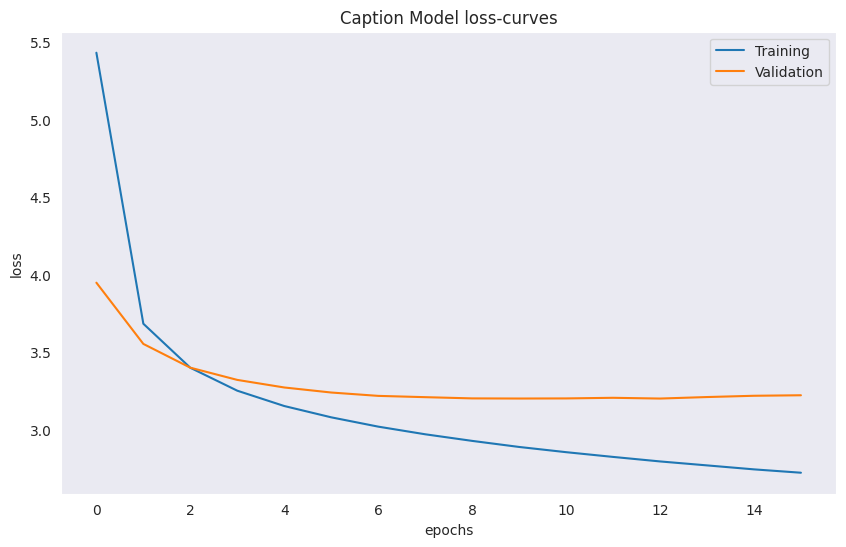

In [38]:
# Loss curves
plt.figure(figsize=(10,6))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Caption Model loss-curves')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='best')
plt.show() 

In [39]:
caption_model.summary()

Model: "image__captioner_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ cnn__encoder_3 (CNN_Encoder)         │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_layer_1          │ ?                           │       1,315,328 │
│ (TransformerEncoderLayer)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_layer_1          │ ?                           │      14,995,216 │
│ (TransformerDecoderLayer)            │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,646,321 (242.79 MB)

 Trainable params: 16,310,544 (62.22 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 32,621,089 (124.44 MB)

In [40]:
# predicted captions will be in the form of index-tokenized captions
# function to convert tokenized_word to textual_word

def get_index_to_word(integer_index, tokenizer):
    vocab = tokenizer.get_vocabulary()
    index_lookup = dict(zip(range(len(vocab)), vocab))
    word = index_lookup[integer_index]
    return word

In [41]:
get_index_to_word(3, tokenizer)

'startseq'

In [42]:
def generate_caption(model, image_path, tokenizer, max_length):
    # Load and preprocess the image
    img = tf.keras.utils.load_img(f"{INPUT_DIR}/Images/{image_path}")
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    img = tf.expand_dims(img, 0)  # Add batch dimension
    
    # Extract features using the CNN model
    img_features = model.cnn_model(img)
    
    # Pass the image features to the Transformer encoder
    encoder_output = model.encoder(img_features, training=False)
    
    # Generate the caption using the Transformer decoder (word by word)
    decoder_input = "startseq"
    result = []
    
    for i in range(max_length-1):
        tokenized_input = tokenizer([decoder_input])[:, :-1]
        
        mask = tf.math.not_equal(tokenized_input, 0)
        # Get the predictions
        predictions = model.decoder(tokenized_input, encoder_output, training=False, mask=mask)
        
        # Get the predicted_token for the last token
        y_pred = np.argmax(predictions[0, i, :])

        # convert tokenized_prediction to word
        word = get_index_to_word(y_pred, tokenizer)

        # If we predict the end token, stop
        if word == "endseq":
            break
            
        # Add the predicted word to the result
        result.append(word)
        
        # Update the decoder input by adding the predicted token
        decoder_input += " " + word 
    
    # Join all words to get caption
    caption = " ".join(result)

    return caption

# Sample Caption generations

In [ ]:
sample_imgs = np.unique(val_imgs[:30]).tolist()
sample_imgs

['261634569.jpg',
 '267836606.jpg',
 '4668777411.jpg',
 '6226359268.jpg',
 '7603002860.jpg',
 '7806899062.jpg']

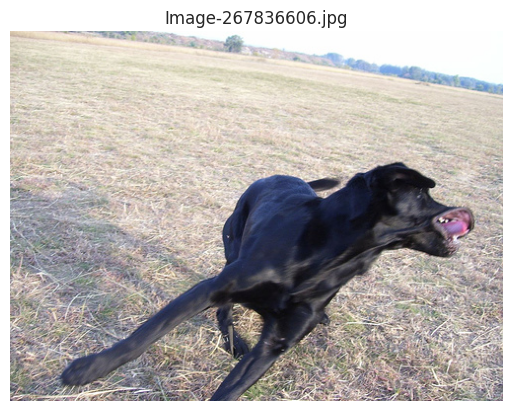

------------ True Captions -------------
startseq a black dog is running with its mouth open across a grassy field . endseq
startseq a black dog has its mouth open while leaning to the side . endseq
startseq a black dog in a flat field attempts to make a turn . endseq
startseq the dog ran in the field . endseq
startseq a black dog barking . endseq
------------ Predicted Caption -----------
a black and white dog is running through the grass .


In [63]:
image = "267836606.jpg"

true_captions = img_to_cap_mapping[image]
pred_caption = generate_caption(caption_model, image, tokenizer, MAX_LENGTH)
img_path = f"{INPUT_DIR}/Images/flickr30k_images/{image}"
img = load_img(img_path, color_mode="rgb")
plt.imshow(img)
plt.title(f"Image-{image}")
plt.axis("off")
plt.show()
print("------------ True Captions -------------")
for true_caption in true_captions:
    print(true_caption)
print("------------ Predicted Caption -----------")
print(pred_caption)
print("===========================================")

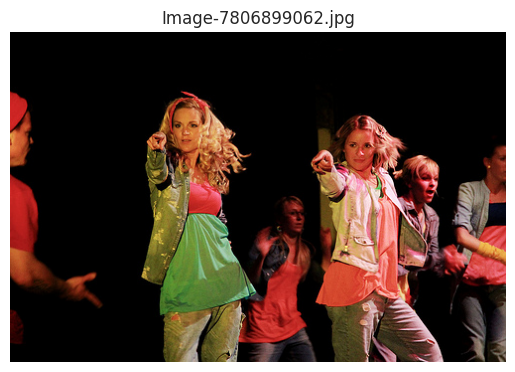

------------ True Captions -------------
startseq two young ladies wearing pink items look to be in the middle of some sort of choreography and are pointing at someone to the side of the picture . endseq
startseq several young people , including a young woman in a green and pink dress , sing and dance . endseq
startseq two women in mixed attire in a dance floor point slightly left of the viewer . endseq
startseq women , who appear to be part of a dance troop , point . endseq
startseq 2 woman dancing while pointing . endseq
------------ Predicted Caption -----------
two women are dancing in a dance studio .


In [64]:
image = "7806899062.jpg"

true_captions = img_to_cap_mapping[image]
pred_caption = generate_caption(caption_model, image, tokenizer, MAX_LENGTH)
img_path = f"{INPUT_DIR}/Images/flickr30k_images/{image}"
img = load_img(img_path, color_mode="rgb")
plt.imshow(img)
plt.title(f"Image-{image}")
plt.axis("off")
plt.show()
print("------------ True Captions -------------")
for true_caption in true_captions:
    print(true_caption)
print("------------ Predicted Caption -----------")
print(pred_caption)
print("===========================================")

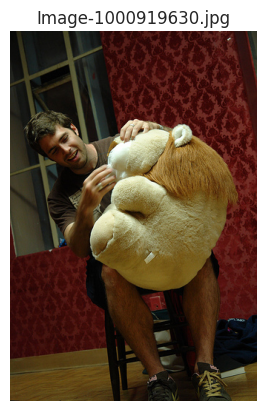

------------ True Captions -------------
startseq a man sits in a chair while holding a large stuffed animal of a lion . endseq
startseq a man is sitting on a chair holding a large stuffed animal . endseq
startseq a man completes the finishing touches on a stuffed lion . endseq
startseq a man holds a large stuffed lion toy . endseq
startseq a man is smiling at a stuffed lion endseq
------------ Predicted Caption -----------
a young boy is playing with a toy .


In [66]:
image = "1000919630.jpg"

true_captions = img_to_cap_mapping[image]
pred_caption = generate_caption(caption_model, image, tokenizer, MAX_LENGTH)
img_path = f"{INPUT_DIR}/Images/flickr30k_images/{image}"
img = load_img(img_path, color_mode="rgb")
plt.imshow(img)
plt.title(f"Image-{image}")
plt.axis("off")
plt.show()
print("------------ True Captions -------------")
for true_caption in true_captions:
    print(true_caption)
print("------------ Predicted Caption -----------")
print(pred_caption)
print("===========================================")

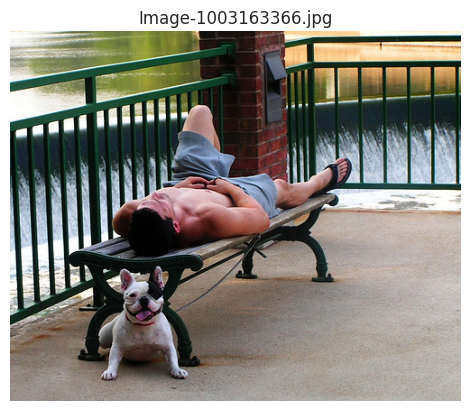

------------ True Captions -------------
startseq a man sleeping on a bench outside with a white and black dog sitting next to him . endseq
startseq a man lays on the bench to which a white dog is also tied . endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
startseq a shirtless man lies on a park bench with his dog . endseq
startseq a man lays on a bench while his dog sits by him . endseq
------------ Predicted Caption -----------
a man is sitting on a bench with his dog .


In [67]:
image = "1003163366.jpg"

true_captions = img_to_cap_mapping[image]
pred_caption = generate_caption(caption_model, image, tokenizer, MAX_LENGTH)
img_path = f"{INPUT_DIR}/Images/flickr30k_images/{image}"
img = load_img(img_path, color_mode="rgb")
plt.imshow(img)
plt.title(f"Image-{image}")
plt.axis("off")
plt.show()
print("------------ True Captions -------------")
for true_caption in true_captions:
    print(true_caption)
print("------------ Predicted Caption -----------")
print(pred_caption)
print("===========================================")

## **Evaluating model with BLEU score**

In [68]:
from nltk.translate.bleu_score import sentence_bleu


def calculate_bleu(reference_captions, predicted_caption):
    """
    reference_captions: list of strings (ground truths)
    predicted_caption: string (generated caption)
    """
    # Tokenize
    references = [ref.split() for ref in reference_captions]
    predicted = predicted_caption.split()
    
    bleu1 = sentence_bleu(references, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = sentence_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4
    }


In [69]:
inference_data = []

img_paths = ["267836606.jpg", "7806899062.jpg", "1000919630.jpg", "1003163366.jpg"]

for img in img_paths:
    ref_captions = data["caption"][data["image"]==img].tolist()
    inference_data.append([img, ref_captions])

In [70]:
inference_data

[['267836606.jpg',
  ['startseq a black dog is running with its mouth open across a grassy field . endseq',
   'startseq a black dog has its mouth open while leaning to the side . endseq',
   'startseq a black dog in a flat field attempts to make a turn . endseq',
   'startseq the dog ran in the field . endseq',
   'startseq a black dog barking . endseq']],
 ['7806899062.jpg',
  ['startseq two young ladies wearing pink items look to be in the middle of some sort of choreography and are pointing at someone to the side of the picture . endseq',
   'startseq several young people , including a young woman in a green and pink dress , sing and dance . endseq',
   'startseq two women in mixed attire in a dance floor point slightly left of the viewer . endseq',
   'startseq women , who appear to be part of a dance troop , point . endseq',
   'startseq 2 woman dancing while pointing . endseq']],
 ['1000919630.jpg',
  ['startseq a man sits in a chair while holding a large stuffed animal of a lio

In [72]:
# Calculate the BLEU Scores 

total_bleu1, total_bleu2, total_bleu3, total_bleu4 = 0, 0, 0, 0
num_samples = len(inference_data)

for img_path, ref_captions in inference_data:
    pred_caption = generate_caption(caption_model, img_path, tokenizer, MAX_LENGTH)
    scores = calculate_bleu(ref_captions, pred_caption)

    total_bleu1 += scores["BLEU-1"]
    total_bleu2 += scores["BLEU-2"]
    total_bleu3 += scores["BLEU-3"]
    total_bleu4 += scores["BLEU-4"]

print("Avg BLEU-1: {:.4f}".format(total_bleu1 / num_samples))
print("Avg BLEU-2: {:.4f}".format(total_bleu2 / num_samples))
print("Avg BLEU-3: {:.4f}".format(total_bleu3 / num_samples))
print("Avg BLEU-4: {:.4f}".format(total_bleu4 / num_samples))

Avg BLEU-1: 0.7140
Avg BLEU-2: 0.4990
Avg BLEU-3: 0.4026
Avg BLEU-4: 0.4408
